In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

print("Project 7 environment ready")


Project 7 environment ready


In [2]:
np.random.seed(42)

# Generate normal login activity
normal_logs = pd.DataFrame({
    "user_id": np.random.randint(1, 20, 300),
    "ip_address": np.random.randint(100, 120, 300),
    "login_success": np.random.choice([0, 1], 300, p=[0.1, 0.9]),  # mostly successful
    "hour": np.random.randint(6, 22, 300)  # normal working hours
})

# Generate suspicious brute-force activity
attack_logs = pd.DataFrame({
    "user_id": np.random.randint(1, 5, 40),
    "ip_address": np.random.randint(200, 205, 40),  # suspicious IP range
    "login_success": 0,  # failed attempts
    "hour": np.random.randint(0, 5, 40)  # odd hours
})

# Combine both
logs = pd.concat([normal_logs, attack_logs]).reset_index(drop=True)

logs.head()


,user_id,ip_address,login_success,hour
0,7,117,0,16
1,15,112,1,6
2,11,106,1,21
3,8,103,1,16
4,7,112,1,16


In [3]:
# Count failed logins per IP
failed_counts = logs[logs["login_success"] == 0].groupby("ip_address").size()

failed_counts.sort_values(ascending=False).head()


ip_address
201    11
200     9
202     8
204     7
112     5
dtype: int64

In [4]:
suspicious_ips = failed_counts[failed_counts > 5].index

logs["rule_bruteforce_flag"] = logs["ip_address"].isin(suspicious_ips)

logs.head()


,user_id,ip_address,login_success,hour,rule_bruteforce_flag
0,7,117,0,16,False
1,15,112,1,6,False
2,11,106,1,21,False
3,8,103,1,16,False
4,7,112,1,16,False


In [5]:
logs["rule_unusual_hour_flag"] = logs["hour"].apply(lambda x: True if x < 6 else False)

logs.head()


,user_id,ip_address,login_success,hour,rule_bruteforce_flag,rule_unusual_hour_flag
0,7,117,0,16,False,False
1,15,112,1,6,False,False
2,11,106,1,21,False,False
3,8,103,1,16,False,False
4,7,112,1,16,False,False


In [6]:
logs["rule_alert"] = logs["rule_bruteforce_flag"] | logs["rule_unusual_hour_flag"]

logs["rule_alert"].value_counts()


rule_alert
False    300
True      40
Name: count, dtype: int64

In [7]:
user_features = logs.groupby("user_id").agg({
    "login_success": lambda x: (x == 0).sum(),  # count failed logins
    "hour": "mean",
    "ip_address": "nunique"
})

user_features.columns = ["failed_attempts", "avg_login_hour", "unique_ips"]

user_features.head()


,failed_attempts,avg_login_hour,unique_ips
user_id,,,
1,16,9.325000,19
2,9,9.807692,19
3,12,10.972222,21
4,7,9.100000,16
5,0,11.428571,11


In [8]:
model = IsolationForest(contamination=0.1, random_state=42)

model.fit(user_features)

user_features["ml_anomaly"] = model.predict(user_features)

user_features.head()


,failed_attempts,avg_login_hour,unique_ips,ml_anomaly
user_id,,,,
1,16,9.325000,19,-1
2,9,9.807692,19,1
3,12,10.972222,21,-1
4,7,9.100000,16,1
5,0,11.428571,11,1


In [9]:
# Convert ML prediction to readable flag
user_features["ml_flag"] = user_features["ml_anomaly"] == -1

# Merge back into logs
logs = logs.merge(user_features[["ml_flag"]], 
                  left_on="user_id", 
                  right_index=True)

logs.head()


,user_id,ip_address,login_success,hour,rule_bruteforce_flag,rule_unusual_hour_flag,rule_alert,ml_flag
0,7,117,0,16,False,False,False,False
1,15,112,1,6,False,False,False,False
2,11,106,1,21,False,False,False,False
3,8,103,1,16,False,False,False,False
4,7,112,1,16,False,False,False,False


In [10]:
logs["final_alert"] = logs["rule_alert"] | logs["ml_flag"]

logs["final_alert"].value_counts()


final_alert
False    249
True      91
Name: count, dtype: int64

In [11]:
logs[logs["final_alert"] == True].head()


,user_id,ip_address,login_success,hour,rule_bruteforce_flag,rule_unusual_hour_flag,rule_alert,ml_flag,final_alert
10,3,113,1,14,False,False,False,True,True
15,1,101,1,13,False,False,False,True,True
25,3,107,0,10,False,False,False,True,True
42,3,118,1,21,False,False,False,True,True
72,1,115,1,19,False,False,False,True,True


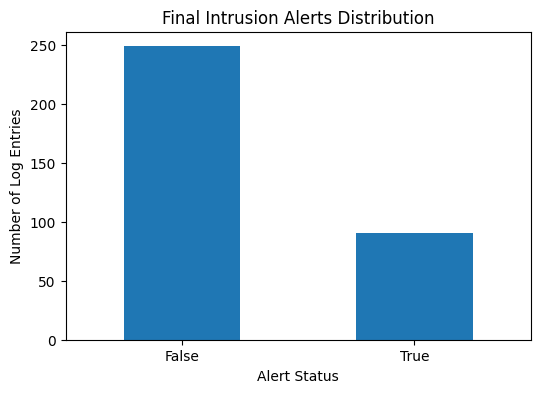

In [12]:
import matplotlib.pyplot as plt

alert_counts = logs["final_alert"].value_counts()

plt.figure(figsize=(6,4))
alert_counts.plot(kind="bar")
plt.title("Final Intrusion Alerts Distribution")
plt.xticks(rotation=0)
plt.xlabel("Alert Status")
plt.ylabel("Number of Log Entries")
plt.show()


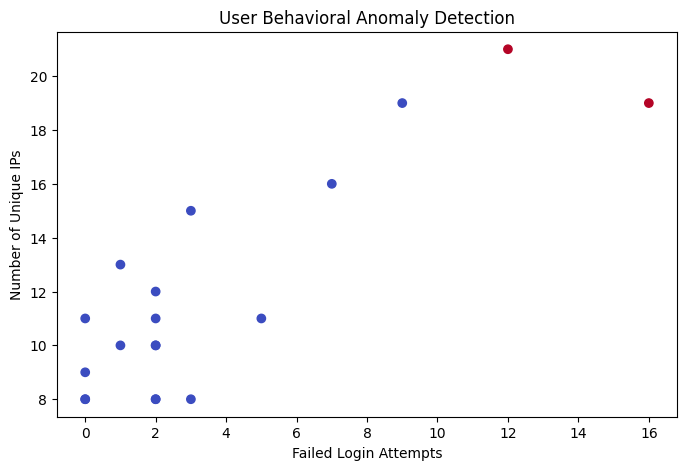

In [13]:
plt.figure(figsize=(8,5))

plt.scatter(
    user_features["failed_attempts"],
    user_features["unique_ips"],
    c=user_features["ml_flag"],
    cmap="coolwarm"
)

plt.xlabel("Failed Login Attempts")
plt.ylabel("Number of Unique IPs")
plt.title("User Behavioral Anomaly Detection")
plt.show()


Hybrid Log-Based Intrusion Detection System

This project implements a simplified hybrid intrusion detection system combining rule-based logic and machine learning.

Rule-Based Layer

The rule-based detection engine flags:

IP addresses with excessive failed login attempts

Login attempts occurring during unusual hours

This simulates traditional signature or threshold-based intrusion detection systems.

Machine Learning Layer

At the behavioral level, Isolation Forest was applied to user-level aggregated features:

Number of failed login attempts

Average login hour

Number of unique IP addresses

This allows the system to detect abnormal user behavior patterns that may not trigger simple rules.

Final Alert Logic

The final alert decision combines:

Rule-based flags

ML-based anomaly detection

If either layer detects suspicious behavior, the event is flagged as a potential intrusion.

Why This Matters

This hybrid approach reflects how modern security systems operate. Pure rule-based systems may miss novel attacks, while pure anomaly detection may generate false positives. Combining both improves robustness and coverage.

This project demonstrates layered security thinking and practical intrusion detection design.